# PYTHON_PROJECT: STOCK ANALYSIS

## IMPORT PACKAGES & DECLARE PARAMETERS

In [19]:
"""from lxml import html  
from time import sleep
import json
import argparse
from collections import OrderedDict"""

import requests
from bs4 import BeautifulSoup
import os
import sys
import bs4

import numpy as np
import pandas as pd

import datetime
import pandas_datareader as web
import statsmodels.api as sm
from statsmodels import regression
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

import certifi
import urllib3
#Making unverified HTTPS requests is strongly discouraged, 
#however, if you understand the risks and wish to disable these warnings, 
#you can use the method below
urllib3.disable_warnings()


global all_stock_detail
global all_income_statement
global all_balance_sheet

global stock_detail
global income_statement
global balance_sheet

global mapping1 #{Company Name: Ticker}
global mapping2 #{Ticker: Company Name}
global stock_name_and_sector
global all_name_and_sector

global company_names
global company_shares #dictionary {stock A :shares,...}
global portfolioValue


from textblob import TextBlob
import tweepy
import requests
import numpy as np
import re
global api

## USER INPUT

In [20]:
#take user input all stocks of an user
def user_input():
    """takes user input to create two global variables: list of company names that user input and list
    of number of shares for each stock
    """
    global company_names
    global company_shares
    numStocks = input('How many companies\' stocks do you own? ')
    company_names = []
    company_shares = []
    for x in range(1,int(numStocks)+1):
        company_names.append(input('Enter company ' +str(x) +": "))
        shares = input("Enter number of shares owned: ")
        while shares.isdigit()==False:
            shares =input('Please input a number:')
        company_shares.append(shares)

## IMPORT CSV

In [3]:
#import csv file into arrays
#csv file contains the information of stocks. i.e. a company name, ticker, industry, sector
def import_csv():
    global mapping1
    global mapping2
    global stock_name_and_sector
    global all_name_and_sector
    data=pd.read_csv("secwiki_tickers.csv")
    stock_name_and_sector = pd.DataFrame(data, columns=['Ticker','Name','Sector'])
    #data.set_index('Name').head()
    name = data ['Name']
    x = [str(x) for x in name]
    ticker = data['Ticker']
    y = [str(x) for x in ticker]
    sector= data['Sector']
    z= [str(x) for x in sector]
    mapping1 = dict(zip(x, y)) #{Company Name: Ticker}
    mapping2 = dict(zip(y,x)) #{Ticker: Company Name}
    all_name_and_sector = dict(zip(y,z))  #{Ticker: Sector}

In [18]:
def search_convert_all(input_stock): 
    """ Takes user input of company names and search the CSV for the company's stock ticker symbol. If similar names 
    for a company found, the funciton displays the names and allows the user to choose the correct company.  
    Arugment:
        input_stock {string} -- user input of company names      
    Returns:
        list -- a list of all tickers symbols found
    """
    global mapping1 
    import_csv()
    all_tickers=[]
    dummy = 0
    for stock in input_stock:
        
        company_name=[]
        for i in mapping1:
            if (stock.lower() in i.lower()):
                company_name.append(i)
       
        company_list = pd.DataFrame(company_name, columns=['Company'], index=list(range(1, len(company_name)+1)))
        if company_list.empty:
            company_names.remove(stock)
            company_shares.remove(company_shares[dummy])
            print('Ticker for company '+stock+' is not found!')
            break;
        elif company_list.shape[0] == 1:
            name = company_list.loc[1].values[0]
            all_tickers.append(mapping1[name])
        else:
            print('Similar company names found for ' + stock+'. Please choose one:')
            print(company_list)
            number = input('Choose the company you want to look at: ')
            number=int(number)
            name = company_list.loc[number].values[0]
            all_tickers.append(mapping1[name])
        dummy+=1
    return all_tickers

## WEB SCRAPING 

In [5]:
#convert bs element into the list of texts
def get_text_from_elements(elements):
    return [e.text.strip() for e in elements]

#convert html into beautifulsoup object
def get_soup_object(page_text):
    soup = bs4.BeautifulSoup(page_text.text, 'html.parser')
    return soup

#get the web page of a ticker
def get_page(ticker , round):
    if(round == 0): url = "http://finance.yahoo.com/quote/%s?p=%s"%(ticker,ticker)
    elif(round == 1): url = url = "http://finance.yahoo.com/quote/%s/financials?p=%s"%(ticker,ticker)
    elif(round == 2): url = url = "http://finance.yahoo.com/quote/%s/balance-sheet?p=%s"%(ticker,ticker)
    response = requests.get(url, verify=False,timeout = 5)
    response.raise_for_status()
    #print ("Parsing %s"%(url))
    return response

#extract the summary of stock detail and convert it into dictionary data
def find_stock_property(soup):
    temp = soup.select('div[id="quote-summary"] table tbody tr td')
    temp = get_text_from_elements(temp)
    header = []
    detail = []
    count = 0
    for element in temp:
        if count%2==0:
            header.append(element)
        elif count%2==1:
            detail.append(element)
        count += 1
    temp =  dict(zip(header, detail))
    return temp

#extract the financial statement of a stock and convert it into dictionary data
def find_financial_statement(soup):
    temp = soup.select('body table tbody tr td')
    temp = get_text_from_elements(temp)
    header = []
    row1 = []
    row2 = []
    row3 = []
    row4 = []
    skip_row = ["Net Income","Operating Expenses", "Income from Continuing Operations","Non-recurring Events"
                ,"Current Assets","Current Liabilities","Stockholders' Equity", ]
    check_net_income = False
    count = 0
    for element in temp:
        if (element in skip_row):
            if(element=="Net Income"):
                if(check_net_income == True):
                    header.append(element)
                    count += 1
                else:
                    check_net_income = True
                    continue
            else:
                continue
        elif count%5==0:
            header.append(element)
            count += 1
        elif count%5==1:
            row1.append(element)
            count += 1
        elif count%5==2:
            row2.append(element)
            count += 1
        elif count%5==3:
            row3.append(element)
            count += 1
        elif count%5==4:
            row4.append(element)
            count += 1

    detail_temp = zip(row1,row2,row3,row4)
    temp =  dict(zip(header, detail_temp))
    return temp

#combine all methods for the webscraping
def web_scraping(ticker):
    global stock_detail
    global income_statement
    global balance_sheet
    page_text = get_page(ticker,0)
    soup = get_soup_object(page_text)
    #temp = soup.prettify()
    #print(temp)
    stock_detail = find_stock_property(soup)
    page_text = get_page(ticker,1)
    soup = get_soup_object(page_text)
    income_statement = find_financial_statement(soup)
    income_statement['Period Ending'] = income_statement.pop('Revenue')
    page_text = get_page(ticker,2)
    soup = get_soup_object(page_text)
    balance_sheet = find_financial_statement(soup)
    
#main function for the webscraping to handle errors and loop through every stock
def web_scraping_all(tickers):
    global all_stock_detail
    global all_income_statement
    global all_balance_sheet
    print('Analyzing portfolio...')
    count = 0
    for stock in tickers:
        try:
            web_scraping(stock)
        except:
            print("ticker "+stock + " is not found.")
            continue
        if(count == 0 ): 
            all_stock_detail = {stock: stock_detail}
            all_income_statement = {stock: income_statement}
            all_balance_sheet = {stock: balance_sheet}
        else: 
            temp = {stock: stock_detail}
            all_stock_detail.update(temp)
            temp = {stock: income_statement}
            all_income_statement.update(temp)
            temp = {stock: balance_sheet}
            all_balance_sheet.update(temp)
        count += 1

# ANALYSIS

In [6]:
def price_to_equity_analysis(ticker):
    """ Takes the stock's PE ratios and returns our score
    Arguments:
        ticker {string}-- the company's stock ticker symbol
    Returns: 
        int -- our own PE score
    """
    pe = (all_stock_detail[ticker])['PE Ratio (TTM)']
    pe = pe.replace(',','')
    pe = float(pe)
    if pe < 10: return 0
    elif pe < 15: return 2
    elif pe < 20: return 4
    elif pe < 25: return 6
    elif pe < 30: return 8
    else: return 10


In [7]:
def price_target_analysis(ticker):
    """ Looks the difference between current stock price and it's 1y expected targe price and returns our own
    price target score
    Arguments:
        ticker {string}-- the company's stock ticker symbol
    Returns: 
        int -- our own price target score
    """
    current_price = all_stock_detail[ticker]['Previous Close']
    current_price = float(current_price.replace(',','').strip())
    year_expected_price = ((all_stock_detail[ticker])['1y Target Est'])
    year_expected_price = float(year_expected_price.replace(',','').strip())
    if current_price > year_expected_price:
        return 0
    elif (current_price - year_expected_price) < 50: return 2
    elif (current_price - year_expected_price) < 100: return 4
    elif (current_price - year_expected_price) < 150: return 6
    elif (current_price - year_expected_price) < 200: return 8
    else: return 10

In [8]:
def price_range_analysis(ticker):
    """ Looks the range of a stock price within the last 52 weeks, creates the array of evenly distributed price
    within this 52-week range, which represents the percentile with 1 decimal digit, then use binary search 
    to find the index, which is the percentile within the 52-range, and converts it into the price range score
    Arguments:
        ticker {string}-- the company's stock ticker symbol
    Returns: 
        int -- our own price range score
    """
    current_price = all_stock_detail[ticker]['Previous Close']
    current_price = float(current_price.replace(',','').strip())
    price_range_52_weeks = all_stock_detail[ticker]['52 Week Range'].replace(',','').split(' - ')
    price_range_52_weeks = np.array(price_range_52_weeks).astype(np.float64)
    min_price = price_range_52_weeks[0]
    max_price = price_range_52_weeks[1]
    different = max_price - min_price
    distribution = np.arange(min_price,max_price+different/1000,different/1000)
    percentile = round(binarySearch(distribution,0,len(distribution)-1,current_price)/100)
    if percentile < 0: return 0
    return percentile

def binarySearch (arr, low, high, key): 
    """Binary search compares the key value or the target value to the middle element of the array. 
    If they are not equal, the half in which the target cannot lie is eliminated 
    and the search continues on the remaining half, again taking the middle element to compare to the target value, 
    and repeating this until the target value is found. if it is not found, it will return -1
    In this method, the recursion technique is used to repeat searching. 
    Arguments:
        arr {float []}-- the array of float or the array of the range of stock prices
        low {int}-- the first index within the search range
        high {int}-- the last index within the search range
        key {float}-- the target value
    Returns: 
        int -- the index of target value
    """
    # Check base case 
    if low <= high: 
        mid = int((low+high)/2)
        if int(arr[mid]) == int(key): return mid 
        elif arr[mid] > key: return binarySearch(arr, low, mid-1, key) 
        else: return binarySearch(arr, mid+1, high, key) 
    else: 
        # Element is not present in the array 
        return -1

In [9]:
def get_marketreturn():
    """web scrape market return rate (SPY ETF) from yahoo finance. 
    Returns: 
        float -- market return rate
    """
    res=requests.get('https://finance.yahoo.com/quote/SPY?p=SPY&.tsrc=fin-srch')
    res.raise_for_status()
    soup = bs4.BeautifulSoup(res.text, 'html.parser')
    element = soup.select('td.Ta(end)')
    for e in element:
        if e['data-test'] == 'YTD_RETURN-value':
            market_return = float(e.span.text.strip()[:-1])/100
    return market_return

def get_riskfree():
    """Web scrape the 10-year risk_free rate from US Treasury Department website
    Returns: 
        float -- risk free rate
    """
    res=requests.get('https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yield')
    res.raise_for_status()
    table = pd.read_html(res.text, index_col=0,header=0)[1]
    risk_free= table['10 yr'].mean()/100
    return risk_free

def calculate_Beta(ticker): #calculate our own beta using linear regression
    """ Takes stocks prices and S&P500 prices for the past 5 months to calculate our own beta for the stock using linear
    Ordinary Least Squares regression. 
    Arguments: 
        ticker {string} -- the company ticker symbol we are calculating a beta score for   
    Returns: 
        float -- the company's beta    
    """
    start=datetime.date.today()- datetime.timedelta(days=5*30)
    end=datetime.date.today()
    stock=web.get_data_yahoo(ticker, start, end)
    market=web.get_data_yahoo("spy", start, end)
    return_stock=stock.Close.pct_change()[1:]
    return_market=market.Close.pct_change()[1:]
    y=return_stock.values
    x=return_market.values
    x=sm.add_constant(x)
    model = regression.linear_model.OLS(y,x).fit()
    return model.params[1]

def calculate_CAPM(ticker): #user put in name of the compan
    """ Take the market return rate, risk free rate and our calucated beta to calculate expected stock return using 
    the CAPM model
    
    Arguments: 
        ticker {string} -- the company ticker symbol we are calculating CAPM for
        
    Returns: 
        float -- the company's CAPM score multiplied by 10 as our own CAPM score
    """
    beta = calculate_Beta(ticker)
    capm = get_riskfree()+beta*(get_marketreturn()-get_riskfree())
    return capm*10

In [10]:
#twitter analysis

# This function is used to establish a communication with the twitter api 
def authentication():
    TWITTER_APP_KEY = 'nryRkm2oqeUQALIXbAiq8CajM'
    TWITTER_APP_SECRET = 'sBJGIqs279CZBNFBGW15VW6B09O1sVZNAFDzgwcGtBgnuUteQj'
    TWITTER_KEY = '1047499950932865026-GlpUatgPiHot8XZbGgv4wdRPuaD8Dn'
    TWITTER_SECRET = 'UDtWNx5tihAQ0EiNa1N5MPYTvR6fRAdCOMwHAqFs4I3Vs'
    auth = tweepy.OAuthHandler(TWITTER_APP_KEY, TWITTER_APP_SECRET)
    auth.set_access_token(TWITTER_KEY, TWITTER_SECRET) 
    global api
    api = tweepy.API(auth)

# This function cleans the tweet and gives us a format that is readable by the TextBlob functionality
def clean (tweet):
    return ''.join(re.sub("'[^A-Za-z0-9]+'"," ''",tweet))


#This function utilizes TextBlob to analyze the sentiment associated with the tweet
def sentiment_analyze(tweet):   
        analysis = TextBlob(clean(tweet)) 
         
        if analysis.sentiment.polarity > 0: 
            return 1
        elif analysis.sentiment.polarity == 0: 
            return 0
        else: 
            return -1
        
# This function is used to fetch the tweets and pass them in an arroay        
def get_tweets(query, count):         
        tweets = [] 
        # the language of tweets is enlish
        # the specified geocode ensures that all the tweets were tweeted for the USA
        get = api.search(q=query, count=count, lang="en", geocode = '39.777593,-98.809220,900mi')
        for tweet in get:        
                final = {} 
                final['text'] = tweet.text 
                final['sentiment'] = sentiment_analyze(tweet.text)
                if final not in tweets:
                    tweets.append(final) 
                else: 
                    tweets.append(final)
        return tweets 
    
# This function is used to return a twitter score based on the sentiment analysis of all the tweets that are parsed 
def twitter_analysis(name): 
    authentication()
    global api
    # we pass the query and number of tweets required
    # the max number of tweets that we can parse is 100
    tweets = get_tweets(query = name, count = 100)
    positive_tweet = [tweet for tweet in tweets if tweet['sentiment'] == 1] 
    negative_tweet = [tweet for tweet in tweets if tweet['sentiment'] == -1]
    neutral_tweet = [tweet for tweet in tweets if tweet['sentiment'] == 0]
    if (len(tweets) > 0):
        twitter_score = (10*(len(positive_tweet)+(len(neutral_tweet)/2))/len(tweets))
        return (twitter_score)
        
    else:
        twitter_score = 5
        return (twitter_score)

In [11]:
def all_analysis(tickers):
    """First Calculates individual stock score with its pe score, price target score, price range score, capm score
    and twitter score. 
    Then calculates the porfolio score by calculating the weighted average of individual company score.
    Arguments: 
        tickers {string} -- the list of company ticker symbols we are calculating score for
    Returns: 
        float -- a weight average of all stocks
    """
    global company_names
    count = 0
    for ticker in tickers:
        if(count == 0 ): 
            portfolio_pe_result = {ticker: price_to_equity_analysis(ticker)}
            portfolio_price_target_result = {ticker: price_target_analysis(ticker)}
            portfolio_price_range_result = {ticker: price_range_analysis(ticker)}
            portfolio_capm_result = {ticker: calculate_CAPM(ticker)}
            portfolio_twitter_result = {ticker: twitter_analysis(company_names[count])}
            company_score = (portfolio_pe_result[ticker] + portfolio_price_target_result[ticker] + portfolio_price_range_result[ticker]
                        +portfolio_capm_result[ticker] + portfolio_twitter_result[ticker]) /5
            company_scores = {ticker: company_score}
        else: 
            portfolio_pe_result.update({ticker: price_to_equity_analysis(ticker)})
            portfolio_price_target_result.update({ticker: price_target_analysis(ticker)})
            portfolio_price_range_result.update({ticker: price_range_analysis(ticker)})
            portfolio_capm_result.update({ticker: calculate_CAPM(ticker)})
            portfolio_twitter_result.update({ticker: twitter_analysis(company_names[count])})
            company_score = ((portfolio_pe_result[ticker] + portfolio_price_target_result[ticker] + portfolio_price_range_result[ticker]
                        +portfolio_capm_result[ticker] + portfolio_twitter_result[ticker])/5)
            company_scores.update({ticker: company_score})
        count += 1
        
            
    portfolio_score = 0
    count = 0
    for ticker in company_scores:
        price = ((all_stock_detail[ticker])['Previous Close'])
        price = price.replace(',','')
        price = price.strip()
        portfolio_score += (company_scores[ticker] * float(company_shares[count]) * float(price))
        count += 1
    portfolio_score = portfolio_score / portfolio_value(tickers)
    return portfolio_score
        

In [12]:
def portfolio_value(tickers):
    """Calculate the value of the portfolio by multiplying numbers of shared owned for an individual stock by the current
    stock price and adding all stocks together
    """
    global company_shares
    global all_stock_detail
    global portfolioValue
    portfolioValue = 0
    for x in range(len(company_names)):
            price = ((all_stock_detail[tickers[x]])['Previous Close'])
            price = price.replace(',','')
            price = price.strip()
            numShares = (company_shares[x])
            numShares = numShares.replace(',','')
            numShares = numShares.strip()
            portfolioValue += (float(price) * int(numShares))
    return portfolioValue



## Visualization

In [13]:
#take an user input to select the stock in a list
#Used in the visualization_individual method below
def user_input_ticker(tickers, ticker=''):
    """check if user input is in the ranges of tickers index. Also check if user inputs an integer."""
    check_input = True
    while(check_input):
        try:
            index = int(input())
            index = index - 1
            ticker = tickers[index]
            check_input = False
        except:
            print("Please enter an integer in a list")
            check_input = True
    return tickers[index] 

#allow an user to select the output of the individual stock
def visualization_individual(tickers):
    global all_stock_detail
    global all_income_statement
    global all_balance_sheet
    
    print("Please select a number of a stock as shown below")
    for i in range(len(tickers)):
        print(str(i+1)+". " + tickers[i])
    
    
    ticker = user_input_ticker(tickers)
    print("You selected "+ticker)
    print("Please select a number of an option as shown below (1,2,3,..)")
    print("1. Stock Detail Summary")
    print("2. Income Statement")
    print("3. Balance Sheet")
    print("4. Correlation Compared to Another Stock")
    
    options = [all_stock_detail[ticker],all_income_statement[ticker],all_balance_sheet[ticker]]
    
    check_input = True
    while(check_input):
        try:
            option = int(input())
            option -=1
            if(option == 3): shown_output = ""
            else: shown_output = (options[option])
            check_input = False
        except:
            print("Please enter an integer in a list")
            check_input = True
    print("You selected the option: "+ str(option+1))
    if(option == 0 ):
        temp = pd.DataFrame(shown_output, [ticker])
        temp2 = temp.T
        display(temp2)
    elif(option == 1):
        temp = pd.DataFrame(shown_output,all_income_statement[ticker]['Period Ending'])
        temp.drop(['Period Ending'], axis=1,inplace = True)
        temp2 = temp.T
        display(temp2)
    elif(option == 2): 
        temp = pd.DataFrame(shown_output,all_balance_sheet[ticker]['Period Ending'])
        temp.drop(['Period Ending'], axis=1,inplace = True)
        temp2 = temp.T
        display(temp2)
    elif(option == 3):
        print("Please select the number of a stock to compare with as shown below (1,2,3...)")
        for i in range(len(tickers)):
            print(str(i+1)+". " + tickers[i])
        ticker2 = user_input_ticker(tickers,ticker)
        industry_analysis(ticker,ticker2)
        
def portfolio_display(tickers):
    """Displays a summary of the portolio, including company name, shares owned, company ticker and company sector
    """
    legal_name_list=[]
    sector_list=[]
    for ticker in tickers:
        legal_name_list.append(mapping2[ticker])
        sector_list.append(all_name_and_sector[ticker])
    portfolio = pd.DataFrame({'Shares Owned':company_shares,'Ticker Symbol':tickers,'Industry':sector_list},index=legal_name_list)
    portfolio.columns.name='PORTFOLIO SUMMARY'
    return portfolio

#output all scores of each stock and the portfolio
def visualization(tickers,col_name):
    portfolio_pe=[]
    portfolio_price_target=[]
    portfolio_price_range=[]
    portfolio_capm=[]
    portfolio_average = []
    for ticker in tickers:
        print("Analyzing " + ticker+"...")
        
        temp = price_to_equity_analysis(ticker)
        portfolio_pe.append(temp)
        
        temp2 =price_target_analysis(ticker)
        portfolio_price_target.append(temp2)
        
        temp3 =price_range_analysis(ticker)
        portfolio_price_range.append(temp3)
        
        temp4 = calculate_CAPM(ticker)
        portfolio_capm.append(temp4)
        
        temp5 = (temp+temp2+temp3+temp4)/4
        portfolio_average.append(temp5)
        
    portfolio_pe_average = pd.Series(portfolio_pe).mean()
    portfolio_pe.insert(0, portfolio_pe_average)
    
    portfolio_price_target_average = pd.Series(portfolio_price_target).mean()
    portfolio_price_target.insert(0, portfolio_price_target_average)
    
    portfolio_price_range_average = pd.Series(portfolio_price_range).mean()
    portfolio_price_range.insert(0, portfolio_price_range_average)
    
    portfolio_capm_average=pd.Series(portfolio_capm).mean()
    portfolio_capm.insert(0, portfolio_capm_average)
    
    temp = pd.Series(portfolio_average).mean()
    portfolio_average.insert(0, temp)
    
    column_names = tickers.copy()
    column_names.insert(0,"Portfolio")
    
    final_output = pd.DataFrame({"PE Analysis":portfolio_pe,"Price Target Analysis":portfolio_price_target,
                   "Price Range Analysis":portfolio_price_range,"CAPM Analysis":portfolio_capm,
                    "Score":portfolio_average},index=column_names)
    
    return final_output.T

#look at the correlation between two stocks
def industry_analysis(ticker1, ticker2):
    """ Takes stock prices for the past five years for each company and plots the price distribution for each stock.
    Also plots the correlation of stock prices to looks at how the stocks have moved together.
    """
    start = datetime.date.today() - datetime.timedelta(days=5*365)
    end = datetime.date.today()
    stock1 = web.DataReader(ticker1, 'yahoo', start, end)
    stock2 = web.DataReader(ticker2, 'yahoo', start, end)
    industry_comp = pd.concat([stock1['Open'], stock2['Open']],axis=1)
    industry_comp.columns = [ticker1, ticker2]
    scatter_matrix(industry_comp,figsize=(6,6),alpha=0.2,hist_kwds={'bins':50})
    plt.show()

## Main Method

How many companies' stocks do you own? 1
Enter company 1: google
Enter number of shares owned: 1
['GOOG']


PORTFOLIO SUMMARY,Shares Owned,Ticker Symbol,Industry
Google Inc.,1,GOOG,Technology


Analyzing portfolio...
Analyzing GOOG...


,Portfolio,GOOG
PE Analysis,10.000000,10.000000
Price Target Analysis,2.000000,2.000000
Price Range Analysis,4.000000,4.000000
CAPM Analysis,1.355229,1.355229
Score,4.338807,4.338807


Do you want to look at individual stocks in your portfolio (y/n)?y
Please select a number of a stock as shown below
1. GOOG
1
You selected GOOG
Please select a number of an option as shown below (1,2,3,..)
1. Stock Detail Summary
2. Income Statement
3. Balance Sheet
4. Correlation Compared to Another Stock
4
You selected the option: 4
Please select the number of a stock to compare with as shown below (1,2,3...)
1. GOOG
1


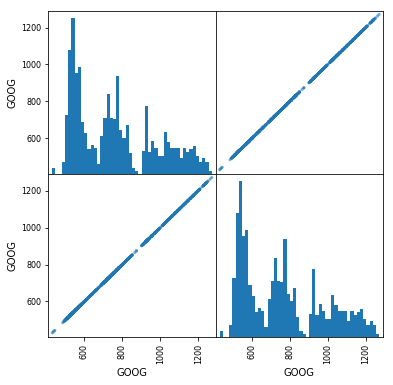

In [ ]:
def main():
    user_input()
    tickers = search_convert_all(company_names)
    print(tickers)
    display(portfolio_display(tickers))
    web_scraping_all(tickers)
    portfolio = visualization(tickers,['Portfolio'])
    display(portfolio)
    checkInput = True
    
    #receive input again for an individual stock in the portfolio
    while(checkInput):
        temp_input = input('Do you want to look at individual stocks in your portfolio (y/n)?')
        if temp_input == 'y':
            checkInput = True
            visualization_individual(tickers)
        elif temp_input == 'n':
            checkInput = False
        else:
            print("please enter the answer again (y/n)")
            checkInput = True
            
if __name__ == "__main__":
    main()
